# Data

In [1]:
import numpy as np
import torch
from mf_functions import forrester_low, forrester_high
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import gpytorch
r"""
Assume conventional design matrix format - observations are rows
"""
x_h = torch.tensor([0,0.4,0.6,1])
i_h = torch.full((len(x_h),1), 1)
x_l = torch.linspace(0,1,12)
i_l = torch.full((len(x_l),1), 0)
y_l = torch.as_tensor(forrester_low(np.array(x_l).reshape(-1,1)))
y_h = torch.as_tensor(forrester_high(np.array(x_h).reshape(-1,1)))

train_X = torch.cat([x_l, x_h]).unsqueeze(-1)
train_I = torch.cat([i_l, i_h])
train_Y = torch.cat([y_l, y_h]).unsqueeze(-1)

scalerX = MinMaxScaler().fit(train_X)
scalerY = StandardScaler().fit(train_Y)

train_Y = torch.as_tensor(scalerY.transform(train_Y)).squeeze(-1)
train_X = torch.as_tensor(scalerX.transform(train_X))

# Model

In [2]:
from model import LinearARModel

model = LinearARModel(train_X, train_Y, train_I, epoch=1000)
model.build()

100%|██████████| 1000/1000 [00:07<00:00, 136.06it/s, loss=-.0743]


# Predict

In [3]:
X = scalerX.inverse_transform(train_X)
Y = scalerY.inverse_transform(train_Y.unsqueeze(-1))

pred_x = torch.linspace(0, 1, 100,  dtype=torch.double).unsqueeze(-1)
pred_i = torch.full((pred_x.shape[0],1), dtype=torch.long, fill_value=1)
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    mean, var = model.predict(pred_x, pred_i)
x = torch.tensor(scalerX.inverse_transform(pred_x).squeeze(-1))
mean = torch.as_tensor(scalerY.inverse_transform(mean.unsqueeze(-1)).squeeze(-1))
upper,lower = mean+2*torch.sqrt(var), mean-2*torch.sqrt(var)

# Evaluate

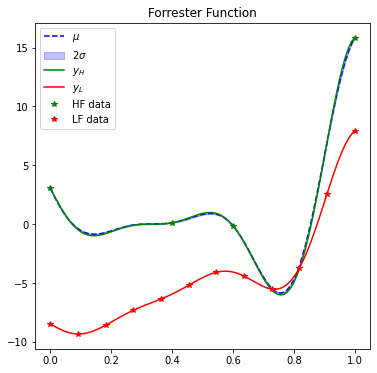

In [4]:
from matplotlib import pyplot as plt

f,ax = plt.subplots(1, 1, figsize=(6, 6))
plt.title("Forrester Function")
ax.plot(x, mean, 'b--')
ax.fill_between(x, lower, upper, color='b', alpha=0.25)
ax.plot(x, forrester_high(np.array(pred_x).reshape(-1,1)), 'g')
ax.plot(x, forrester_low(np.array(pred_x).reshape(-1,1)), 'r')
ax.plot(X[train_I==1], Y[(train_I==1)], 'g*')
ax.plot(X[train_I==0], Y[(train_I==0)], 'r*')
ax.legend(['$\mu$','$2\sigma$','$y_H$','$y_L$','HF data','LF data'])